In [ ]:
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm
from dataset.FastPatchExtractor import FastPatchDataset, FastPatchExtractor
from operators.noise_operator import NoiseOperator
import torch
from patchNR.model import create_NF

In [3]:
mean=0
std = 20
operator = NoiseOperator(mean, std)

NameError: name 'NoiseOperator' is not defined

In [4]:
rec_image = FastPatchDataset('data/material_pt_nr/test.png', 9).images[0]
deg_rec_image = operator(rec_image)

NameError: name 'FastPatchDataset' is not defined

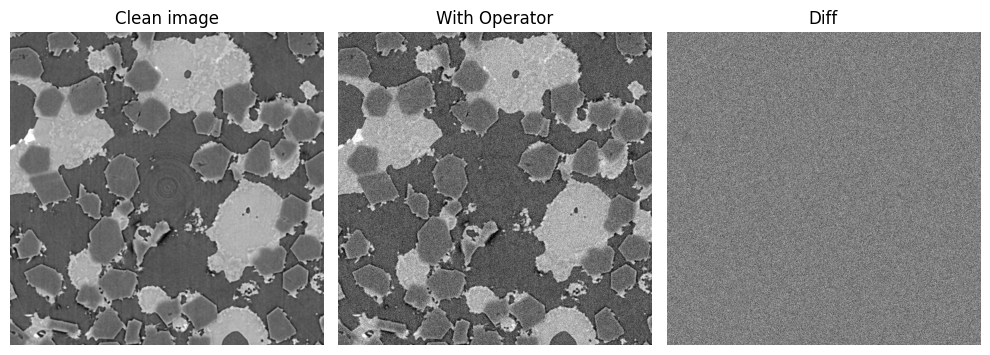

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(rec_image.squeeze(), cmap='gray')
axes[0].set_title('Clean image')
axes[0].axis('off')
axes[1].imshow(deg_rec_image.squeeze(), cmap='gray')
axes[1].set_title(f'With Operator')
axes[1].axis('off')
axes[2].imshow((deg_rec_image-rec_image).squeeze(), cmap='gray')
axes[2].set_title(f'Diff')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [7]:
weight = '../patchNR/patchNR_weights/weights_material.pth'

In [8]:
patch_size = 6
num_layers = 5
subnet_nodes = 512
net = create_NF(num_layers, subnet_nodes, dimension=patch_size**2)
weights = torch.load('../patchNR/patchNR_weights/weights_material.pth', map_location='cpu')
net.load_state_dict(weights['net_state_dict'])

<All keys matched successfully>

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
def reconstruct(img, lam, patch_size, n_patches_out, model, n_iter_max):
    """
    Defines the reconstruction using patchNR as regularizer
    """

    # fixed parameters
    obs = img
    operator = NoiseOperator(mean=0, std=20)
    center = False
    init = obs
    pad_size = 4 #pad the image before extracting patches to avoid boundary effects
    pad = [pad_size]*4

    # create patch extractors
    patch_extractor = FastPatchExtractor(patch_size, pad=False, center=center)

    # intialize optimizer for image
    fake_img = init.clone().detach().requires_grad_(True)
    optim_img = torch.optim.Adam([fake_img], lr=0.01)

    bar = tqdm(range(n_iter_max))
    # Main loop
    for it in bar:
        optim_img.zero_grad()
        tmp = nn.functional.pad(fake_img, pad, mode='reflect')
        fake_data = patch_extractor.extract(tmp, n_patches_out)

        #patchNR
        pred_inv, log_det_inv = model(fake_data,rev=True)
        reg = torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)

        #data fidelity
        data_fid = torch.sum((operator(fake_img) - obs)**2)

        #loss
        loss = data_fid + lam*reg
        bar.set_description_str('D/R: 0.2f - %0.2f| L: %0.2f'.format(data_fid, reg, loss))
        loss.backward()
        optim_img.step()
    return fake_img

cpu


In [10]:
lam = 2.5
n_pat = 40000
iteration = 100
rec = reconstruct(deg_rec_image, lam = lam, patch_size = patch_size, n_patches_out = n_pat,
              model = net, n_iter_max = iteration)

D/R: 0.2f - %0.2f| L: %0.2f:   2%|▏         | 2/100 [00:13<11:16,  6.91s/it]


KeyboardInterrupt: 

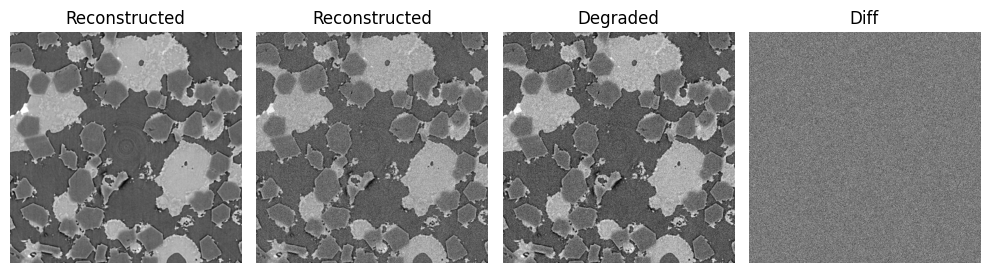

In [80]:
reconstructed = rec.detach()
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(rec_image.squeeze(), cmap='gray')
axes[0].set_title('Reconstructed')
axes[0].axis('off')
axes[1].imshow(reconstructed.squeeze(), cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image.squeeze(), cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
axes[3].imshow((rec_image-reconstructed).squeeze(), cmap='gray')
axes[3].set_title(f'Diff')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [81]:
patch_extractor = FastPatchExtractor(50)

In [89]:
ground_truth = torch.reshape(patch_extractor.extract(rec_image)[3], (50,50))
reconstructed = torch.reshape(patch_extractor.extract(reconstructed)[3], (50,50))
deg_rec_image = torch.reshape(patch_extractor.extract(deg_rec_image)[3], (50,50))

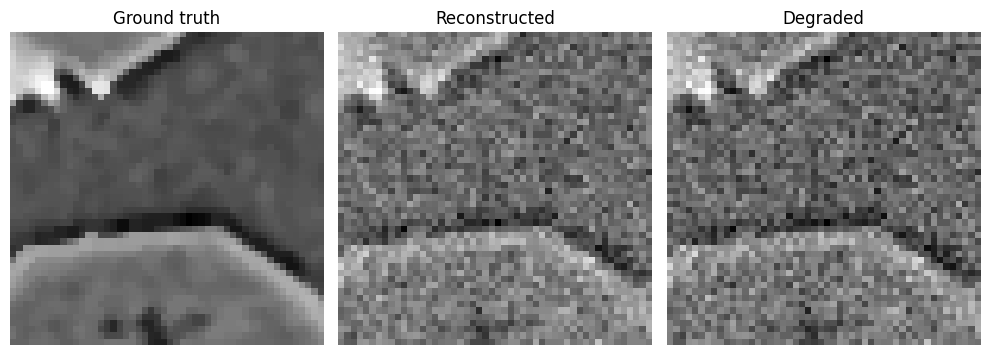

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(ground_truth, cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image, cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
plt.tight_layout()
plt.show()